![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [225]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv


In [226]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [227]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Рассмотрим данные датасета

In [228]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [229]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [230]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [231]:
"""Проанализируем датасет а наличие пропусков и типов данных"""
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [232]:
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

Посчитаем число уникальных элементов

In [233]:
data.nunique()

Restaurant_id        13094
City                    31
Cuisine Style        10731
Ranking              12975
Price Range              3
Number of Reviews     1573
Reviews              41857
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

Подробнее о признаках:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [234]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
47532,id_1851,Dublin,NaN,1855.0,NaN,9.0,"[['New development above the river.', 'Croissa...",/Restaurant_Review-g186605-d12357191-Reviews-T...,d12357191,1,3.0
8236,id_8236,Rome,NaN,4314.0,NaN,7.0,"[[], []]",/Restaurant_Review-g187791-d11784264-Reviews-L...,d11784264,0,0.0
12249,id_1833,Hamburg,NaN,1836.0,NaN,6.0,"[['Great experience!', ""There is only one dish...",/Restaurant_Review-g187331-d8531697-Reviews-Di...,d8531697,1,5.0
32066,id_102,Geneva,"['American', 'Vegetarian Friendly']",103.0,$$ - $$$,135.0,"[['Some of the best burgers in Geneve', 'Most ...",/Restaurant_Review-g188057-d7132107-Reviews-To...,d7132107,1,4.5
3901,id_3901,Amsterdam,NaN,2978.0,NaN,4.0,"[['It is Burger King', 'Inefficient ‘Order Pro...",/Restaurant_Review-g188590-d12328261-Reviews-B...,d12328261,0,0.0


In [235]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Очистка и подготовка данных

**##Предобрадотка данных
![](http://)**### 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [236]:
# создаем доп признаки содержащие информацию о значениях NAN
data['Number_of_Reviews_NAN'] = pd.isna(data['Number of Reviews']).astype('float64')
data['Price Range_NaN'] = pd.isna(data['Price Range']).astype('float64') 
data['Cuisine Style_NaN'] = pd.isna(data['Cuisine Style']).astype('object')
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_NAN,Price Range_NaN,Cuisine Style_NaN
31236,id_1016,Copenhagen,"['European', 'Swedish', 'Danish', 'Norwegian']",1018.0,$,3.0,"[['Simply amazing find', 'Amazing and cosy wit...",/Restaurant_Review-g189541-d12115109-Reviews-K...,d12115109,1,5.0,0.0,0.0,False
29284,id_822,Madrid,['Japanese'],823.0,$$ - $$$,35.0,"[['Japan in Madrid'], ['12/22/2017']]",/Restaurant_Review-g187514-d12146457-Reviews-U...,d12146457,1,4.5,0.0,0.0,False
20227,id_1821,Rome,NaN,1822.0,NaN,47.0,"[[], []]",/Restaurant_Review-g187791-d12667696-Reviews-L...,d12667696,1,4.5,0.0,1.0,True
32850,id_736,Oslo,NaN,737.0,NaN,4.0,"[['cheap + cheerful AND really good', 'Good an...",/Restaurant_Review-g190479-d9697252-Reviews-Su...,d9697252,1,4.5,0.0,1.0,True
22749,id_8733,Madrid,['Spanish'],8741.0,NaN,14.0,"[[], []]",/Restaurant_Review-g187514-d3438603-Reviews-La...,d3438603,1,1.0,0.0,1.0,False


Преобразуем Number of Reviews и Price Range 

In [237]:
#преобразуем Price Range, заполним пропуски средним значением цены
data['Price Range'] = data.apply(lambda x: x['Price Range'].replace('$$ - $$$', '2').replace('$$$$', '3').replace('$', '1')
                                 if type(x['Price Range']) == str else 2,axis = 1)
data['Price Range'] = data.apply(lambda x: float(x['Price Range']), axis = 1)
data['Price Range'].value_counts()


2.0    40402
1.0     7816
3.0     1782
Name: Price Range, dtype: int64

In [238]:
#преобразуем Number of Reviews, удалим выбросы и заполним пропуски средним значением цены
#опишем функцию по удалению выбросов
def cut_emissions(x):
    median = x.median()
    IQR = x.quantile(0.75) - x.quantile(0.25)
    perc25 = x.quantile(0.25)
    perc75 = x.quantile(0.75)
    x = x.loc[x.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    return x
#удалим выбросы(если они есть)
cut_emissions(data['Number of Reviews'])
cut_emissions(data['Price Range'])



0        2.0
1        2.0
2        2.0
7        2.0
8        2.0
        ... 
49995    2.0
49996    2.0
49997    2.0
49998    2.0
49999    2.0
Name: Price Range, Length: 40402, dtype: float64

* ![](http://)Преобразуем Cuisine Style, кодируем данный признак по разделителю ',' с помощью get_dummies ¶


In [239]:
data['Cuisine Style'].fillna('1', inplace=True)
data['Cuisine Style'] = data.apply(lambda x: x['Cuisine Style'].replace('[','').replace(']','').replace("'",'').replace(' ','') 
                                  if type(x['Cuisine Style']) != float else x['Cuisine Style'], axis = 1)
data = data.join(data['Cuisine Style'].str.get_dummies(','), how = 'left')


Создадим новые признаки на основании дат отзывов

In [240]:
data['dates_of_Review']=data['Reviews'].str.findall('\d+/\d+/\d+')

Text(0.5, 1.0, 'распределение Price Range')

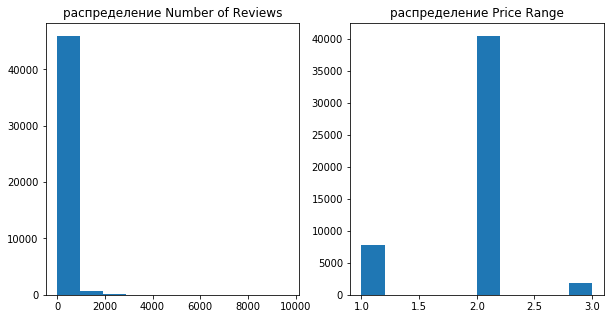

In [241]:
#построим гистограммы
fig, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].hist(data['Number of Reviews'])
axes[0].set_title('распределение Number of Reviews')

axes[1].hist(data['Price Range'])
axes[1].set_title('распределение Price Range') 



In [242]:
data['Number of Reviews'].value_counts()

2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: Number of Reviews, Length: 1573, dtype: int64

Создадим новый признак - количество заведений в городе

In [243]:
count_city = data.City.value_counts()
data['in_City'] = data.apply(lambda x: count_city[x.City], axis = 1)
data['in_Ranking'] = data.Ranking / data.in_City
 
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,VegetarianFriendly,Venezuelan,Vietnamese,Welsh,WineBar,Xinjiang,Yunnan,dates_of_Review,in_City,in_Ranking
36894,id_654,Rome,"Italian,Pizza,Mediterranean,VegetarianFriendly...",655.0,2.0,1448.0,"[['Superb!', 'Best pizza of our life!'], ['11/...",/Restaurant_Review-g187791-d6748185-Reviews-Em...,d6748185,1,...,1,0,0,0,0,0,0,"[11/26/2017, 10/29/2017]",2589,0.252993
42270,id_1309,Dublin,1,1312.0,2.0,3.0,"[['Cakes', 'delish!'], ['03/19/2015', '03/11/2...",/Restaurant_Review-g186605-d3510857-Reviews-Ba...,d3510857,1,...,0,0,0,0,0,0,0,"[03/19/2015, 03/11/2013]",836,1.569378
24166,id_3883,Paris,"French,European",3884.0,2.0,172.0,"[['A friendly neighbourhood café', 'Good food ...",/Restaurant_Review-g187147-d2010332-Reviews-Lu...,d2010332,1,...,0,0,0,0,0,0,0,"[11/24/2017, 09/15/2017]",6108,0.635887
12543,id_1740,Berlin,1,1742.0,2.0,17.0,"[['Great food', 'A great Sunday night at Nikol...",/Restaurant_Review-g187323-d7755777-Reviews-Sp...,d7755777,1,...,0,0,0,0,0,0,0,"[04/28/2016, 09/04/2015]",2705,0.643993
32875,id_11528,London,"Japanese,Asian,Sushi",11538.0,2.0,14.0,"[['Great takeaway sushi', 'Yummy food and frie...",/Restaurant_Review-g186338-d1097367-Reviews-To...,d1097367,1,...,0,0,0,0,0,0,0,"[08/21/2017, 09/06/2016]",7193,1.604060


Преобразуем City, кодируем данный признак с помощью get_dummies 

In [244]:
#data = pd.get_dummies(data, columns=[ 'City'], dummy_na=True)

In [245]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,VegetarianFriendly,Venezuelan,Vietnamese,Welsh,WineBar,Xinjiang,Yunnan,dates_of_Review,in_City,in_Ranking
0,id_0,Paris,"Bar,Pub",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,0,0,0,0,[],6108,2.122299
1,id_1,Helsinki,"European,Scandinavian,GlutenFreeOptions,Vegeta...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,1,0,0,0,0,0,0,"[12/05/2017, 10/29/2017]",475,0.223158
2,id_2,Edinburgh,VegetarianFriendly,810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,1,0,0,0,0,0,0,"[12/28/2017, 12/06/2017]",745,1.087248
3,id_3,London,"Italian,Mediterranean,European,VegetarianFrien...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,1,0,0,0,0,0,0,"[12/06/2017, 11/22/2017]",7193,0.232031
4,id_4,Bratislava,"Italian,Mediterranean,European,Seafood,Vegetar...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,1,0,0,0,0,0,0,"[02/08/2018, 01/24/2018]",380,0.097368


In [246]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,VegetarianFriendly,Venezuelan,Vietnamese,Welsh,WineBar,Xinjiang,Yunnan,dates_of_Review,in_City,in_Ranking
31401,id_13538,London,American,13548.0,2.0,2.0,"[['good', 'average'], ['01/01/2017', '02/09/20...",/Restaurant_Review-g186338-d4919307-Reviews-KF...,d4919307,1,...,0,0,0,0,0,0,0,"[01/01/2017, 02/09/2016]",7193,1.883498
49793,id_1913,Copenhagen,Steakhouse,1918.0,2.0,20.0,"[['Fine', 'Cheap but the food and service is b...",/Restaurant_Review-g189541-d8291060-Reviews-Bo...,d8291060,1,...,0,0,0,0,0,0,0,"[08/01/2017, 06/08/2017]",819,2.341880
11797,id_1790,Vienna,1,1791.0,2.0,NaN,"[[], []]",/Restaurant_Review-g190454-d11771269-Reviews-P...,d11771269,1,...,0,0,0,0,0,0,0,[],1443,1.241164
25446,id_2748,Milan,1,2750.0,2.0,20.0,[['Excellent place for lunch or for a drink i....,/Restaurant_Review-g187849-d7994318-Reviews-La...,d7994318,1,...,0,0,0,0,0,0,0,"[05/24/2017, 10/28/2016]",2694,1.020787
40519,id_6779,Madrid,Seafood,6782.0,2.0,62.0,"[['A busy place', 'Traditional restaurant with...",/Restaurant_Review-g187514-d2258938-Reviews-Lo...,d2258938,1,...,0,0,0,0,0,0,0,"[07/01/2016, 03/25/2015]",3813,1.778652


# ### Посмотрим распределение признака Ranking

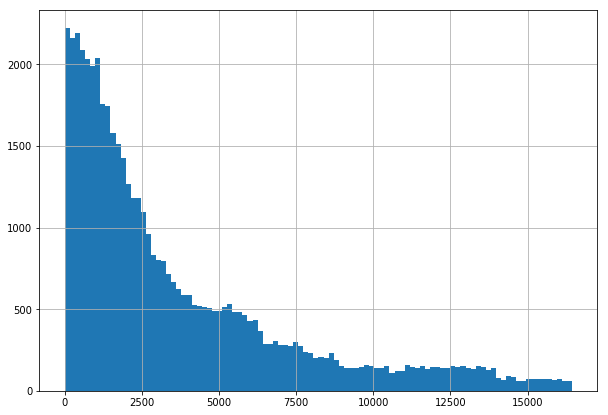

In [247]:
plt.rcParams['figure.figsize'] = (10,7)
data['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

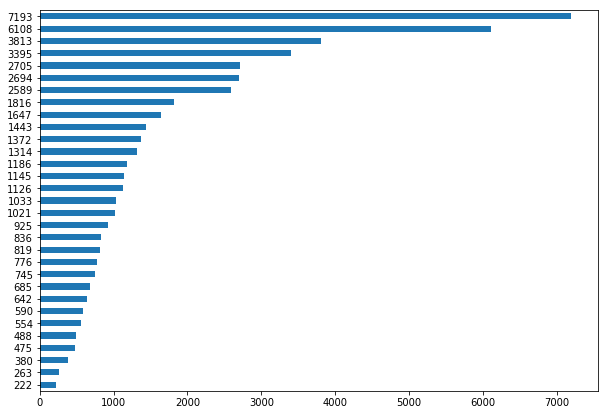

In [248]:
data['in_City'].value_counts(ascending=True).plot(kind='barh')

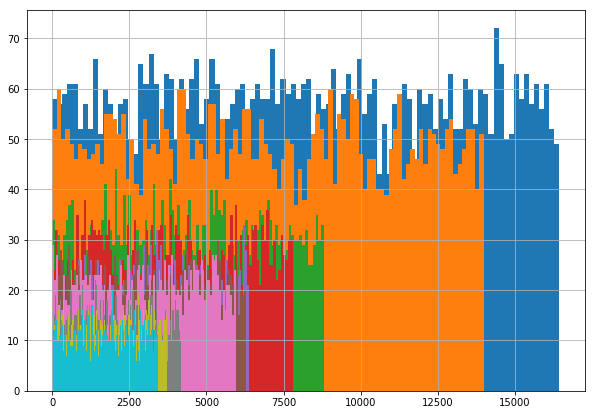

In [249]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

1. > ##нормализуем распределение Ranking относительно City

In [250]:
mean_Ranking_on_City = data.groupby(['City'])['Ranking'].mean()
count_Restorant_in_City = data['City'].value_counts(ascending=False)
data['mean_Ranking_on_City'] = data['City'].apply(lambda x: mean_Ranking_on_City[x])
data['count_Restorant_in_City'] = data['City'].apply(lambda x: count_Restorant_in_City[x])
data['norm_Ranking_on_Rest_in_City'] = (data['Ranking'] - data['mean_Ranking_on_City']) / data['count_Restorant_in_City']
data.sample(5)

max_Ranking_on_City = data.groupby(['City'])['Ranking'].max()
data['max_Ranking_on_City'] = data['City'].apply(lambda x: max_Ranking_on_City[x])
data['norm_Ranking_on_maxRank_in_City'] = (data['Ranking'] - data['mean_Ranking_on_City']) / data['max_Ranking_on_City']


Проверим результат нормализации

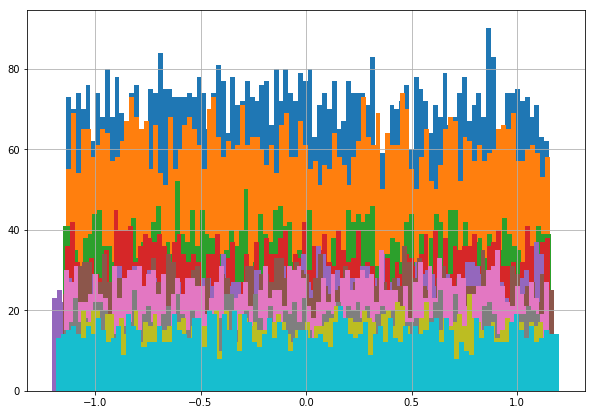

In [251]:
for x in (data['City'].value_counts())[0:10].index:
    data['norm_Ranking_on_Rest_in_City'][data['City'] == x].hist(bins=100)
plt.show()

построим boxplot для Ranking

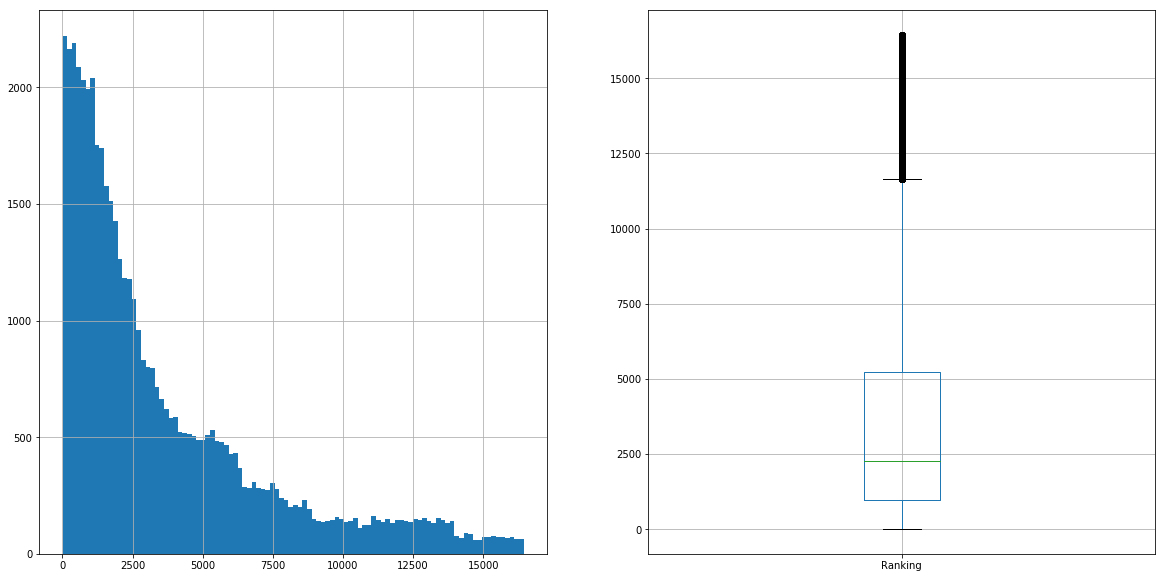

In [252]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10));
data['Ranking'].hist(bins=100, ax=axes[0])
data.boxplot(column='Ranking', ax=axes[1])


### Посмотрим распределение целевой переменной

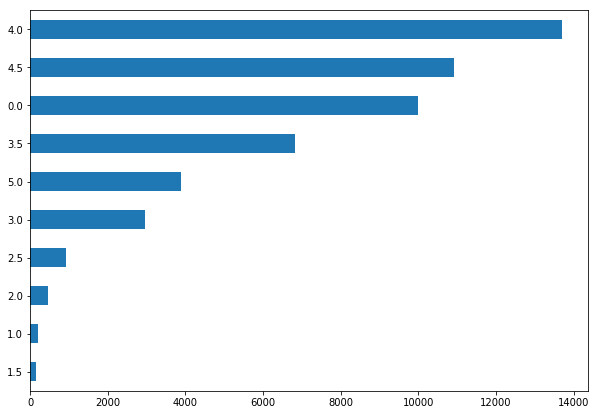

In [253]:
data['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

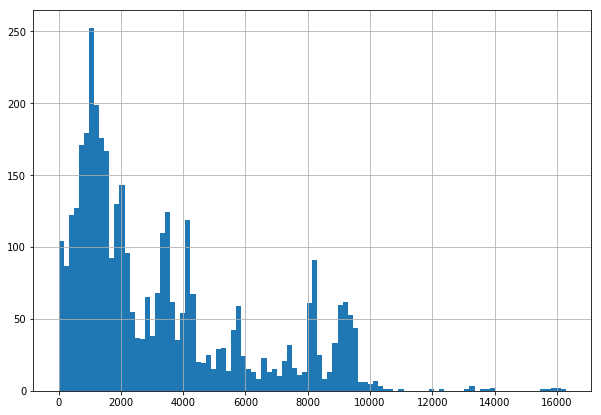

In [254]:
data['Ranking'][data['Rating'] == 5].hist(bins=100)

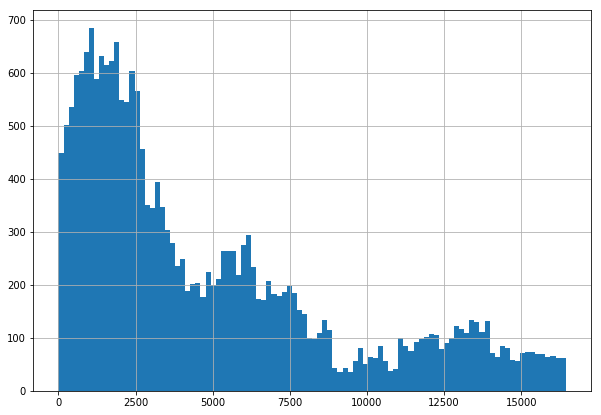

In [255]:
data['Ranking'][data['Rating'] < 4].hist(bins=100)

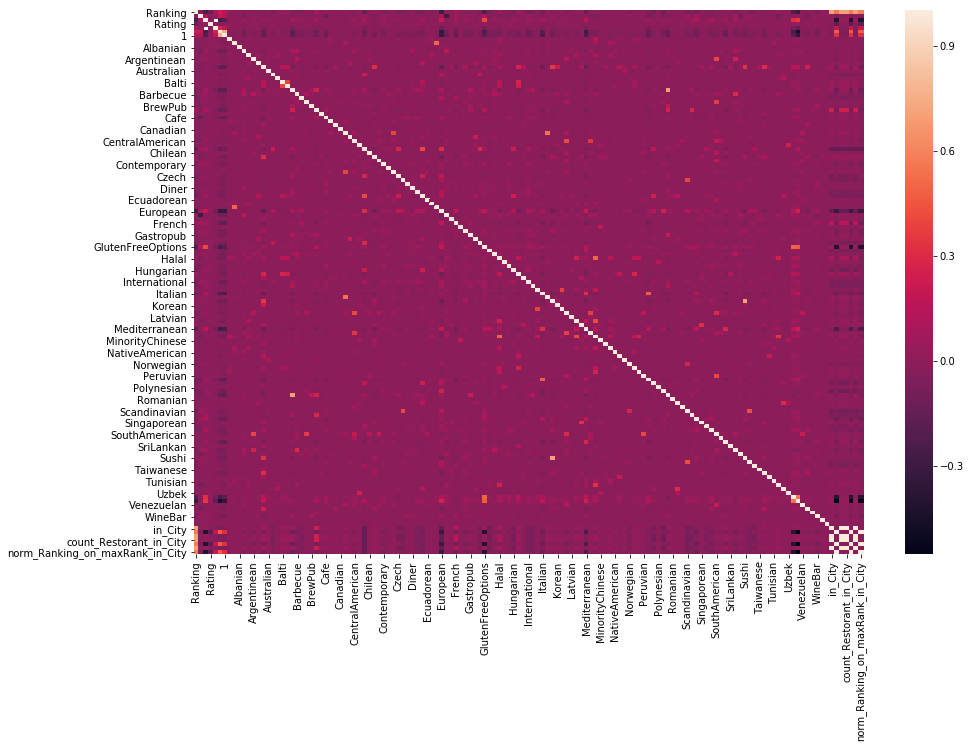

In [256]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [257]:
"""Нормализуем признак Ranking относительно количества заведений в городе"""
data['in_Ranking'] = data.Ranking / data.in_City
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Xinjiang,Yunnan,dates_of_Review,in_City,in_Ranking,mean_Ranking_on_City,count_Restorant_in_City,norm_Ranking_on_Rest_in_City,max_Ranking_on_City,norm_Ranking_on_maxRank_in_City
38446,id_1437,Vienna,"Bar,Cafe,Pub,WineBar",1438.0,2.0,16.0,"[['Perfect cocktails', 'Excellent'], ['05/09/2...",/Restaurant_Review-g190454-d4550958-Reviews-Ba...,d4550958,1,...,0,0,"[05/09/2017, 11/28/2015]",1443,0.996535,1711.275814,1443,-0.189380,3444.0,-0.079348
32066,id_102,Geneva,"American,VegetarianFriendly",103.0,2.0,135.0,"[['Some of the best burgers in Geneve', 'Most ...",/Restaurant_Review-g188057-d7132107-Reviews-To...,d7132107,1,...,0,0,"[12/02/2017, 11/19/2017]",590,0.174576,713.227119,590,-1.034283,1413.0,-0.431866
25424,id_737,Milan,"Italian,Pizza,Mediterranean,VegetarianFriendly...",739.0,2.0,1041.0,[['Good home made pasta - beware of hidden ch....,/Restaurant_Review-g187849-d3916214-Reviews-La...,d3916214,1,...,0,0,"[12/03/2017, 11/29/2017]",2694,0.274313,3106.027840,2694,-0.878629,6275.0,-0.377216
34404,id_383,Luxembourg,"European,Portuguese,Mediterranean",384.0,1.0,25.0,"[['Cibo quasi impeccabile', 'Like hone'], ['09...",/Restaurant_Review-g190356-d6597649-Reviews-Re...,d6597649,1,...,0,0,"[09/06/2017, 05/13/2017]",263,1.460076,308.159696,263,0.288366,621.0,0.122126
2364,id_2364,London,1,9176.0,2.0,2.0,"[['Great Cuppa', 'Delicious coffee, friendly s...",/Restaurant_Review-g186338-d8705042-Reviews-Tr...,d8705042,0,...,0,0,"[09/07/2016, 10/07/2015]",7193,1.275685,8169.707354,7193,0.139899,16444.0,0.061195


# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [258]:
# повторно импортируем данне
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [259]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA','URL_TA'], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    
    # создаем доп признаки содержащие информацию о значениях NAN
    df_output['Number_of_Reviews_NAN'] = pd.isna(df_output['Number of Reviews']).astype('float64')
    df_output['Price Range_NaN'] = pd.isna(df_output['Price Range']).astype('float64') 
    #Заполняем пропуски нулями
    df_output['Number of Reviews'].fillna(0, inplace=True)
    #Заполняем пропуски 2, предврительно преобразовав признак в числовой
    df_output['Price Range'] = df_output.apply(lambda x: x['Price Range'].replace('$$ - $$$', '2').replace('$$$$', '3').replace('$', '1')
                                 if type(x['Price Range']) == str else 2,axis = 1)
    df_output['Price Range'] = df_output.apply(lambda x: float(x['Price Range']), axis = 1)

    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    #Преобразуем Cuisine Style, кодируем данный признак по разделителю ',' с помощью get_dummies 
    df_output['Cuisine Style'].fillna('1', inplace=True)
    df_output['Cuisine Style'] = df_output.apply(lambda x: x['Cuisine Style'].replace('[','').replace(']','').replace("'",'').replace(' ','') 
                                  if type(x['Cuisine Style']) != float else x['Cuisine Style'], axis = 1)
    df_output = df_output.join(data['Cuisine Style'].str.get_dummies(','), how = 'left')
    
    
    
    
    # ################### 4. Feature Engineering ####################################################
    #Новый признак - количество заведений в городе
    count_Restorant_in_City = df_output.City.value_counts()
    df_output['count_Restorant_in_City'] = df_output.apply(lambda x: count_Restorant_in_City[x.City], axis = 1)
        
    #Нормализуем признак Ranking относительно количества заведений в городе
    df_output['norm_in_Ranking'] = df_output.Ranking / df_output.count_Restorant_in_City
    
    #Новый признак средний Ranking ресторанов в городах
    mean_Ranking_on_City = df_output.groupby(['City'])['Ranking'].mean()
    df_output['mean_Ranking_on_City'] = df_output['City'].apply(lambda x: mean_Ranking_on_City[x])
    #нормализуем
    df_output['norm_Ranking_on_Rest_in_City'] = (df_output['Ranking'] - df_output['mean_Ranking_on_City']) / df_output['count_Restorant_in_City']
    
    max_Ranking_on_City = df_output.groupby(['City'])['Ranking'].max()
    df_output['max_Ranking_on_City'] = df_output['City'].apply(lambda x: max_Ranking_on_City[x])
    df_output['norm_Ranking_on_maxRank_in_City'] = (df_output['Ranking'] - df_output['mean_Ranking_on_City']) / df_output['max_Ranking_on_City']
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

#### Запускаем и проверяем что получилось

In [276]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Number_of_Reviews_NAN,Price Range_NaN,'Afghani','Afghani'],'African',...,['Vietnamese',['Vietnamese'],['Wine Bar',['Wine Bar'],count_Restorant_in_City,norm_in_Ranking,mean_Ranking_on_City,norm_Ranking_on_Rest_in_City,max_Ranking_on_City,norm_Ranking_on_maxRank_in_City
30869,733.0,2.0,46.0,1,4.0,0.0,0.0,0,0,0,...,0,0,0,0,1021,0.717924,1219.061704,-0.476064,2440.0,-0.199206
14915,7678.0,1.0,6.0,1,5.0,0.0,0.0,0,0,0,...,0,0,0,0,7193,1.067427,8169.707354,-0.068359,16444.0,-0.029902
32720,248.0,2.0,12.0,1,4.0,0.0,0.0,0,0,0,...,0,0,0,0,380,0.652632,462.428947,-0.564287,889.0,-0.241202
27731,5129.0,2.0,55.0,1,4.0,0.0,0.0,0,0,0,...,0,0,0,0,6108,0.839718,6938.557138,-0.296260,13986.0,-0.129383
31461,3131.0,2.0,7.0,1,4.5,0.0,0.0,0,0,0,...,0,0,0,0,3813,0.821138,4388.516391,-0.329797,8809.0,-0.142754
30149,408.0,2.0,8.0,1,4.5,0.0,1.0,0,0,0,...,0,0,0,0,380,1.073684,462.428947,-0.143234,889.0,-0.061225
16476,1860.0,3.0,174.0,1,4.5,0.0,0.0,0,0,0,...,0,0,0,0,2589,0.718424,2970.733102,-0.429020,5948.0,-0.186741
46481,12724.0,2.0,2.0,1,4.0,0.0,1.0,0,0,0,...,0,0,0,0,7193,1.768942,8169.707354,0.633156,16444.0,0.276958
2136,5525.0,2.0,0.0,0,0.0,1.0,1.0,0,0,0,...,0,0,0,0,2694,2.050854,3106.027840,0.897911,6275.0,0.385494
2958,997.0,2.0,59.0,0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,6108,0.163229,6938.557138,-0.972750,13986.0,-0.424822


In [261]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 445 entries, Ranking to norm_Ranking_on_maxRank_in_City
dtypes: float64(11), int64(434)
memory usage: 169.8 MB


In [277]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [278]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [279]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 444), (40000, 444), (40000, 443), (32000, 443), (8000, 443))

# Model 
Сам ML

In [280]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [281]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [282]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [283]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21118874999999998


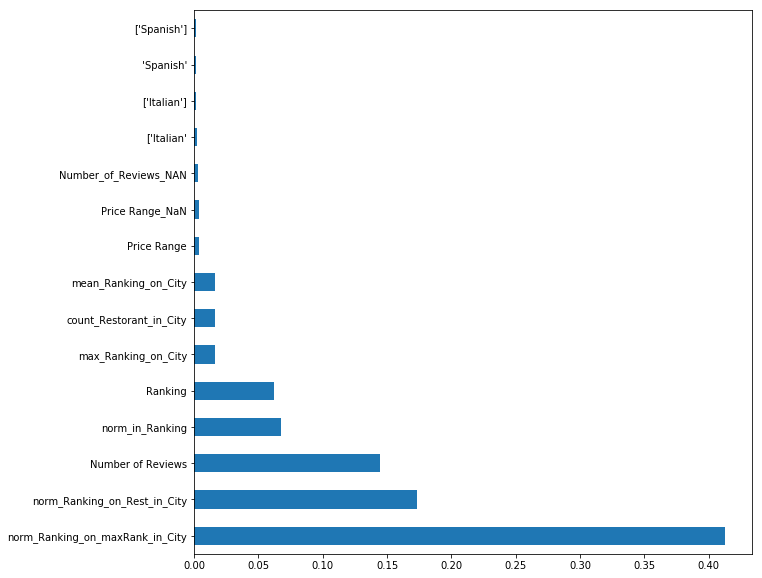

In [269]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [270]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number_of_Reviews_NAN,Price Range_NaN,'Afghani','Afghani'],'African','African'],...,['Vietnamese',['Vietnamese'],['Wine Bar',['Wine Bar'],count_Restorant_in_City,norm_in_Ranking,mean_Ranking_on_City,norm_Ranking_on_Rest_in_City,max_Ranking_on_City,norm_Ranking_on_maxRank_in_City
6097,480.0,2.0,169.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,1145,0.419214,1370.297817,-0.777553,2763.0,-0.322221
6235,309.0,2.0,56.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,1443,0.214137,1711.275814,-0.971778,3444.0,-0.407165
5813,2076.0,2.0,187.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,2589,0.801854,2970.733102,-0.345590,5948.0,-0.150426
5767,484.0,2.0,70.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,685,0.706569,794.280292,-0.452964,1601.0,-0.193804
5815,1617.0,2.0,11.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,819,1.974359,982.147741,0.775155,1964.0,0.323245
7496,11428.0,2.0,3.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,7193,1.588767,8169.707354,0.452981,16444.0,0.198145
2643,671.0,2.0,12.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,590,1.137288,713.227119,-0.071571,1413.0,-0.029885
6292,4368.0,2.0,38.0,0.0,0.0,1.0,0,0,0,0,...,0,0,0,0,2589,1.687138,2970.733102,0.539694,5948.0,0.234914
7783,4109.0,2.0,272.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,7193,0.571250,8169.707354,-0.564536,16444.0,-0.246942
7939,6341.0,2.0,166.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,3813,1.662995,4388.516391,0.512060,8809.0,0.221646


In [271]:
test_data = test_data.drop(['Rating'], axis=1)

In [272]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [273]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [274]:
predict_submission

array([3.05 , 4.295, 4.055, ..., 3.03 , 4.465, 4.18 ])

In [275]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.050
1,id_1,4.295
2,id_2,4.055
3,id_3,4.315
4,id_4,4.435
5,id_5,4.535
6,id_6,2.650
7,id_7,2.565
8,id_8,4.145
9,id_9,4.745


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
